In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
import galaxyfunctions as func

from astropy import units as u
from scipy.constants import G

In [43]:
#import mass lists
size_list = np.load('galaxy_size_list.npy')
bm_list = np.load('bulge_mass_list.npy')
dm_list = np.load('disk_mass_list.npy')
hm_list = np.load('halo_mass_list.npy')
m_tot = bm_list + dm_list + hm_list

### initial velocity 
stars at $$ (x, y) = (r \cos \theta, r \sin \theta) $$  
orbital velocity with elliptical orbit:  
$$
\vec v (r) = \sqrt{\frac{GM_{in}(r)}{r} - \frac{GM_{in}(r)}{a}} \hat v = \sqrt{\frac{GM_{in}(r)}{r}- \frac{GM_{in}(r)}{a}}(\cos(\theta - 90^\circ), \sin(\theta - 90^\circ))
$$  
  
  https://theskylive.com/sky/deepsky/ngc1300-object

In [3]:
#changing units
msun_kg = ((1*u.solMass)/(1*u.kg)).to(u.kg/u.kg).value
kpc_m = ((1*u.kpc)/(1*u.meter)).to(u.meter/u.meter).value
s_myr = ((1*u.s)/(1*u.Myr)).to(u.s/u.s).value

In [4]:
a = 30.3 / 2 #semi-major axis length
b = 20.7 / 2 #semi-minor axis length

def mass_array(r_list, src = 'full'):
    idx = np.argmin(abs(size_list[:, np.newaxis] - r_list[np.newaxis,:]), axis = 0)
    if src == 'full':
        return m_tot[idx]
    elif src == 'bulge':
        return bm_list[idx]
    elif src == 'disk':
        return dm_list[idx]
    elif src == 'halo':
        return hm_list[idx]
    else:
        print("Error!")
        print(src)
        assert False
    
def v(r_list, src = 'full'):
        print('src:', src)

        v_list = []
        v_list.append(np.sqrt((G*mass_array(r_list, src) * msun_kg / (r_list * kpc_m)) - (G*mass_array(r_list, src) * msun_kg / (a * kpc_m))))
                      
        return np.array(v_list)[0]
    
def vi(r, theta):
        v1 = v(r)
        vx = (v1*np.cos(theta - np.pi/2)/s_myr/kpc_m) / (np.sqrt(a) * kpc_m)
        vy = (v1*np.sin(theta - np.pi/2)/s_myr/kpc_m) / (np.sqrt(b) * kpc_m)
        return vx, vy
    

### save, load inital conditions

In [5]:
def initial(N_objects, r_min, r_max, M_min, M_max):
    theta0 = np.random.uniform(0, 2*np.pi, N_objects)
    r0 = np.random.uniform(r_min, r_max, N_objects)
    m_list = np.random.uniform(M_min, M_max, N_objects)
    
    vx0, vy0 = vi(r0, theta0)
    
    x0 = r0 * a * np.cos(theta0)
    y0 = r0 * b * np.sin(theta0)
    return x0, y0, vx0, vy0, m_list

In [6]:
N_objects = 1000
r_min = 0.01
r_max = 1 
M_min = 0.1
M_max = 10

x0, y0, vx0, vy0, m_list = initial(N_objects, r_min, r_max, M_min, M_max)

src: full


In [7]:
with open('initial_conditions.npy', 'wb') as f:
    np.save(f, [x0, y0, vx0, vy0])
    
with open('star_masses.npy', 'wb') as f:
    np.save(f, m_list)

In [53]:
x0, y0, vx0, vy0 = np.load('initial_conditions.npy')
m_list = np.load('star_masses.npy')

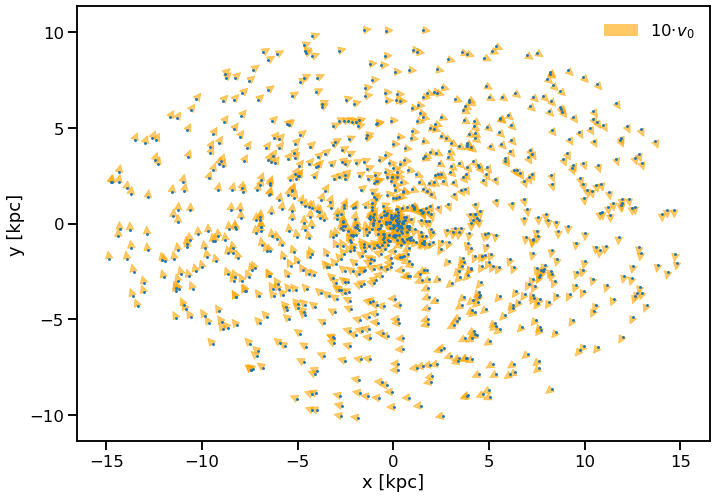

<Figure size 432x288 with 0 Axes>

In [184]:
plt.figure(figsize = (17, 8))

ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')

plt.scatter(x0,y0,s=2,zorder=1)
for x,y,vx,vy in zip(x0,y0,vx0,vy0):
    arr = plt.arrow(x,y,vx*10,vy*10,lw=0.7,color='orange',alpha=0.6,zorder=0,head_width=0.4,head_length=0.4)
plt.legend([arr],[r'10$\cdot v_0$'],frameon=False,loc=1)
plt.show()
plt.savefig('initial_condition.PNG',bbox_to_inches='tight')

### N-body simulation: force  
gravitational force between two objects:  
$$
\vec F _{i j} = \frac{GM_{i}M_{j}}{r_{i j}^2} \hat r = \frac{GM_{i}M_{j}}{r_{i j}^2} \frac{\vec{r_{i j}}}{\left\lvert r_{i j} \right\rvert} = \frac{GM_{i}M{j}}{r_{i j}^3} \vec r
$$

In [37]:
def F(xlist, ylist, mlist):
    dx = -(xlist[:, np.newaxis] - xlist[np.newaxis,:]) * kpc_m
    dy = -(ylist[:, np.newaxis] - ylist[np.newaxis,:]) * kpc_m
    d = np.sqrt(np.add(np.power(dx, 2), np.power(dy, 2)))
    d3 = np.power(d, 3)
    
    mm = (mlist[:, np.newaxis] * mlist[np.newaxis,:]) * msun_kg**2
    Gmm = np.multiply(G, mm)
    
    fxn = np.nansum(np.multiply(np.divide(Gmm, d3), dx), axis = 1)
    fyn = np.nansum(np.multiply(np.divide(Gmm, d3), dy), axis = 1)
    
    r = np.sqrt(xlist**2 + ylist**2)
    m = mass_array(r) * msun_kg
    fxg = G * m * (mlist * msun_kg)/(r * kpc_m)**3 * (-xlist * kpc_m)
    fyg = G * m * (mlist * msun_kg)/(r * kpc_m)**3 * (-ylist * kpc_m)
    
    fx = fxn + fxg
    fy = fyn + fyg
    return fx, fy

In [38]:
for _ in range(100):
    fx, fy = F(x0, y0, m_list)

In [39]:
Fx,Fy = F(x0,y0,m_list)

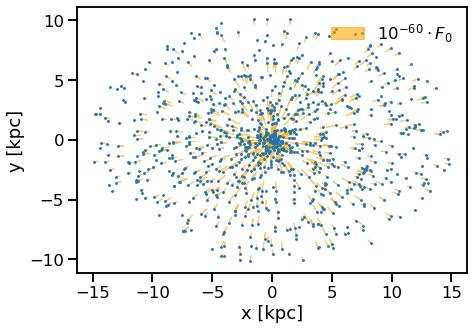

In [183]:
fig,ax1 = plt.subplots(1,1,figsize=(7,7))
ax1.scatter(x0,y0,s=2,zorder=1)
for x,y,fx,fy in zip(x0,y0,Fx,Fy):
    arr = ax1.arrow(x,y,fx*1e-26,fy*1e-26,lw=1,color='orange',alpha=0.6,zorder=0)
ax1.legend([arr],[r'$10^{-60}\cdot F_0$'],frameon=False,loc=1)
ax1.set_aspect('equal')
ax1.set_xlabel('x [kpc]')
ax1.set_ylabel('y [kpc]')
plt.savefig('force.PNG',bbox_to_inches='tight')

### N-body simulation: differential equation  
motion of objects described by the following parameters
$ x_{i}(t) $, 
$ y_{i}(t) $, 
$ v_{x, i}(t) $,
$ v_{y, i}(t) $. starting from t = 0:  

$
x_{i}(t + \Delta t) = x_{i}(t) + \frac{dx_{i}}{dt} \Delta t 
$  

$
y_{i}(t + \Delta t) = x_{i}(t) + \frac{dy_{i}}{dt} \Delta t  
$  

$
v_{x, i}(t + \Delta t) = v_{x, i}(t) + \frac{dv_{x, i}}{dt} \Delta t 
$  

$
v_{y, i}(t + \Delta t) = v_{y, i}(t) + \frac{dv_{y, i}}{dt} \Delta t
$

In [14]:
a_rescale = (1/kpc_m)/(s_myr**2)

In [167]:
def deriv(val, M_list):
    x_list, y_list, vx_list, vy_list = val
    
    dxdt = vx_list
    dydt = vy_list
    
    Fx, Fy = F(x_list, y_list, M_list)
    dvxdt = (Fx*1e-26) / (M_list * msun_kg) * a_rescale
    dvydt = (Fy*1e-26) / (M_list * msun_kg) * a_rescale
    
    return np.array([dxdt, dydt, dvxdt, dvydt])

In [168]:
def RK4(val_old, dt, M_list):
    val_old = np.array(val_old)
    k1 = val_old + 0.5*dt*deriv(val_old, M_list) 
    k2 = val_old + 0.5*dt*deriv(k1, M_list)
    k3 = val_old + dt*deriv(k2, M_list)
    k4 = dt*deriv(k3, M_list)
    
    return (k1 + 2*k2 + k3)/3 + k4/6 - val_old/3

### Simulation

In [169]:
#check if rest works first

from warnings import filterwarnings
filterwarnings(action='ignore')

In [170]:
def simulation(val0, M_list, dt, t_max, save):
    t = 0
    val_old = val0
    data = []
    t_list = []
    while t <= t_max:
        val_new = RK4(val_old, dt, M_list) 
        t += dt
        
        if t % save == 0:
            data.append(val_new)
            t_list.append(t)
        val_old = val_new
    return data, t_list

In [171]:
val0 = [x0, y0, vx0*1e17, vy0*1e17]
dt = 0.5
tmax = 100
save = 1

data, t_list = simulation(val0, m_list, dt, tmax, save) 

In [172]:
with open('data.npy', 'wb') as f:
    np.save(f, [data, t_list])

### animation

In [179]:
from matplotlib.animation import FuncAnimation
#remove second axis

def animation(data_a, t_lista, filename, fps = 60, distinguish_extra_obj = False, alpha = 1.0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 8))
    
    x1, y1 = [], []
    x2, y2 = [], []
    x3, y3 = [], []
    
    sc1, = ax1.plot(x1, y1, marker = 'o', ls = '', ms = 15, zorder = 1, markeredgecolor = 'none', color = 'pink')
    sc2, = ax1.plot(x2, y2, marker = 'o', ls = '', ms = 2, zorder = 1, markeredgecolor = 'none', color = 'purple', alpha = alpha)
    sc3, = ax2.plot(x3, y3, marker ='o', ls = '', ms = 2, markeredgecolor = 'none', alpha = alpha)
    text = ax1.text(10, 35, '', fontdict={'color':'lightblue', 'size':20})
    
    def init():
        ax1.set_aspect('equal')
        ax1.set_xlim(-20, 20)
        ax1.set_ylim(-20, 20)
        ax1.set_xlabel('x [kpc]')
        ax1.set_ylabel('y [kpc]')
        ax2.set_xlabel('r [kpc]')
        ax2.set_ylabel('v [kpc/Myr]')
        ax2.set_ylim(0, 30)
        ax2.set_xlim(0, 40)
        fig.patch.set_facecolor('black')
        
        for ax in [ax1, ax2]:
            ax.set_facecolor('black')
            ax.spines['bottom'].set_color('lightblue')
            ax.spines['top'].set_color('lightblue')
            ax.spines['right'].set_color('lightblue')
            ax.spines['left'].set_color('lightblue')
            ax.xaxis.label.set_color('lightblue')
            ax.yaxis.label.set_color('lightblue')
            ax.tick_params(axis = 'x', colors = 'lightblue')
            ax.tick_params(axis = 'y', colors = 'lightblue')
            
        return sc1, sc2, sc3, text,
    
    def update(frame):
        x, y, vx, vy = data_a[frame]
        
        if distinguish_extra_obj:
            sc1.set_data(x[0], y[0])
            sc2.set_data(x[1:], y[1:])
            sc3.set_data(np.sqrt(x**2 + y**2)[1:], np.sqrt(vx**2 + vy**2)[1:])
        else:
            sc2.set_data(x, y)
            sc3.set_data(np.sqrt(x**2 + y**2), np.sqrt(vx**2 + vy**2))
            text.set_text(f't = {int(t_lista[frame]):} Myr')
            return sc1, sc2, sc3, text,
        
    ani = FuncAnimation(fig, update, frames = len(data_a), init_func = init, blit = True)
    ani.save(filename, fps = fps, dpi = 200, savefig_kwargs = {'facecolor':'black'})
    print('done')

MovieWriter ffmpeg unavailable; using Pillow instead.


done


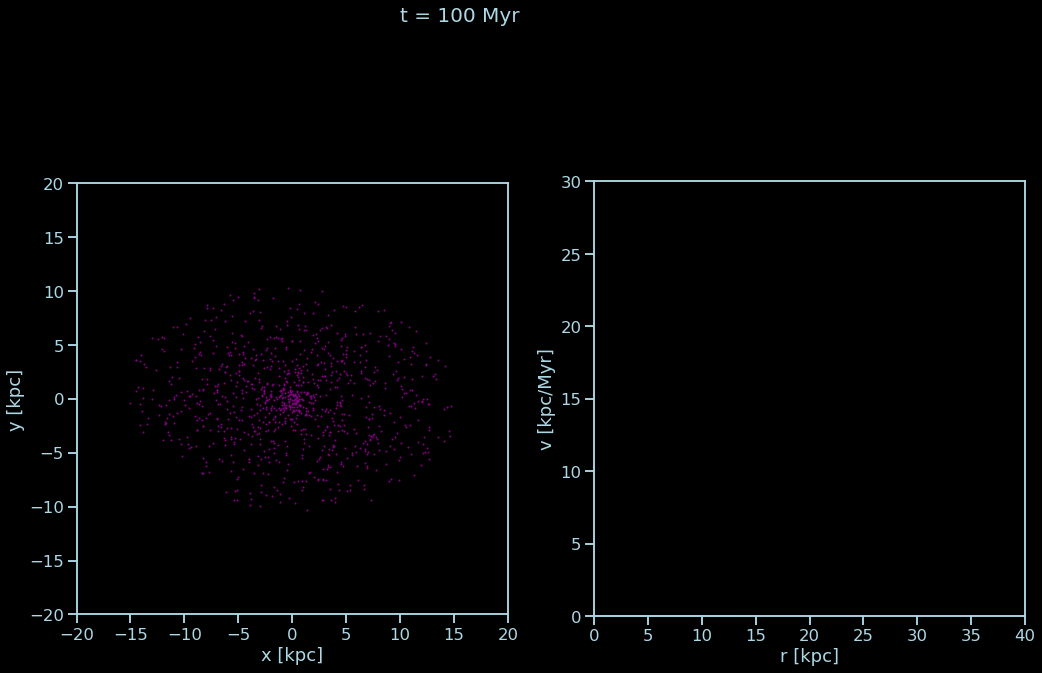

In [180]:
animation(data, t_list, 'galaxyanimation.gif')